# Multimodal RCA – Training

Trains the multimodal root cause analysis model. Transformer encoder on pod metrics + MiniLM log embeddings → fusion → cosine similarity classification against service name embeddings.

98 scenarios total (4 LEMMA + 94 Nezha). See `docs/ARQUITECTURA_MODELO.md` for architecture details.


## 1. Imports and Configuration


In [18]:
import json
import random
import re
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Check GPU availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


Using device: cuda


In [19]:
# === PATHS ===
BASE_DIR = Path("/root/lemm")
MULTIMODAL_DIR = BASE_DIR / "core_multimodal_tmp"
METRICS_DIR = BASE_DIR / "core_metrics_tmp"
LOGS_DIR = BASE_DIR / "core_logs_tmp"

# === MODEL CONFIG (IMPROVED) ===
CONFIG = {
    # Data
    "window_size": 22,          # Use Nezha window size (shortest)
    "n_metrics": 7,             # CPU, Memory, RX, TX, Latency_server, Latency_client, Workload
    "bin_seconds": 30,
    
    # PatchTST / Metric Encoder
    "d_model": 128,             # Embedding dimension
    "n_heads": 4,
    "n_layers": 2,
    "dropout": 0.35,            # Higher to prevent overfitting
    
    # MiniLM
    "log_embed_dim": 384,       # MiniLM output dimension
    
    # Fusion
    "fusion_dim": 256,
    "use_cross_attention": False,  # MAX+MEAN works better for 1:1 pod-service
    
    # Training
    "batch_size": 8,            # Reduced for more regularization (noise per batch)
    "learning_rate": 1e-4,      # Conservative for stability
    "weight_decay": 1e-4,       # Moderate regularization
    "epochs": 50,
    "warmup_epochs": 10,        # Extended warmup - gives model more time to learn
    "temperature": 0.1,         # For similarity softmax
    "label_smoothing": 0.02,    # Very light smoothing
    "grad_clip_norm": 1.0,      # Gradient clipping for stability
    "scheduler_patience": 5,    # Epochs to wait before reducing LR
    "scheduler_factor": 0.5,    # Factor to reduce LR by
    
    # Data Augmentation
    "jitter": 3,                # Temporal jitter (bins)
    "noise_std": 0.1,           # NEW: Gaussian noise on metrics
    "mask_prob": 0.1,           # NEW: Random masking probability
}

# ============================================================================
# DATASET CONFIGURATION - TRAIN/VAL SPLIT (BY DAY - NO OVERLAP)
# ============================================================================
# 
# Strategy: Split by DAY to guarantee ZERO 
# 
# 
#  between train/val
#
# Nezha scenarios have ~8 min gaps between faults, but 10 min windows.
# This causes 85% overlap between consecutive scenarios of the same day.
# By splitting by day, we eliminate ALL data leaks.
#
# EXCLUDED (7 scenarios):
#   - 20220822_nezha_22, 20220822_nezha_23 : Corrupted data
#   - 20230130_nezha_15, 20230130_nezha_16 : Corrupted data
#   - 20220822_nezha_14, 20220823_nezha_21, 20220823_nezha_24 : No signal (Class D)
#
# TRAIN SET (~53 scenarios):
#   - Nezha 20220822: ~21 scenarios (Online Boutique)
#   - Nezha 20230129: ~28 scenarios (Train-Ticket)
#   - LEMMA (all):     4 scenarios (Sock Shop)
#
# VAL SET (~42 scenarios):
#   - Nezha 20220823: ~30 scenarios (Online Boutique)
#   - Nezha 20230130: ~12 scenarios (Train-Ticket)
#
# ============================================================================

EXCLUDED_SCENARIOS = {
    # Corrupted data
    "20220822_nezha_22", "20220822_nezha_23",
    "20230130_nezha_15", "20230130_nezha_16",
    # No detectable signal (Class D)
    "20220822_nezha_14", "20220823_nezha_21", "20220823_nezha_24",
}

# Split by DAY to guarantee zero temporal overlap
TRAIN_DAYS = {"20220822", "20230129"}  # Online Boutique day 1 + Train-Ticket day 1
VAL_DAYS = {"20220823", "20230130"}    # Online Boutique day 2 + Train-Ticket day 2

def get_split(scenario_id: str) -> str:
    """
    Determine if scenario belongs to train or val set.
    
    Split by DAY to guarantee zero temporal overlap between train/val.
    LEMMA scenarios (format: YYYYMMDD) always go to train.
    """
    # Extract date prefix for Nezha scenarios
    if "_nezha_" in scenario_id:
        date_prefix = scenario_id.split("_nezha_")[0]
        if date_prefix in VAL_DAYS:
            return "val"
        elif date_prefix in TRAIN_DAYS:
            return "train"
    
    # LEMMA scenarios always go to train
    return "train"

print("="*70)
print("CONFIGURATION SUMMARY")
print("="*70)
print(f"\nModel: window={CONFIG['window_size']} bins, d_model={CONFIG['d_model']}, metrics={CONFIG['n_metrics']}")
print(f"\nExcluded scenarios ({len(EXCLUDED_SCENARIOS)}):")
for s in sorted(EXCLUDED_SCENARIOS):
    print(f"  - {s}")
print(f"\nSPLIT BY DAY (zero temporal overlap):")
print(f"  TRAIN days: {TRAIN_DAYS} + LEMMA")
print(f"  VAL days:   {VAL_DAYS}")


CONFIGURATION SUMMARY

Model: window=22 bins, d_model=128, metrics=7

Excluded scenarios (7):
  - 20220822_nezha_14
  - 20220822_nezha_22
  - 20220822_nezha_23
  - 20220823_nezha_21
  - 20220823_nezha_24
  - 20230130_nezha_15
  - 20230130_nezha_16

SPLIT BY DAY (zero temporal overlap):
  TRAIN days: {'20220822', '20230129'} + LEMMA
  VAL days:   {'20220823', '20230130'}


## 2. Scenario Discovery


In [20]:
NEZHA_PATTERN = re.compile(r"^\d{8}_nezha_\d+$")
LEMMA_PATTERN = re.compile(r"^\d{8}$")

def detect_dataset(scenario_id: str) -> str:
    """Detect if scenario is from LEMMA or Nezha."""
    if NEZHA_PATTERN.match(scenario_id):
        return "nezha"
    elif LEMMA_PATTERN.match(scenario_id):
        return "lemma"
    return "unknown"

def discover_scenarios() -> List[Dict]:
    """Discover all valid scenarios (excluding problematic ones)."""
    scenarios = []
    excluded_count = 0
    
    for d in sorted(MULTIMODAL_DIR.iterdir()):
        if not d.is_dir():
            continue
        if d.name in EXCLUDED_SCENARIOS:
            excluded_count += 1
            continue
        if not (d / "manifest.json").exists():
            continue
        if not (d / "ground_truth.json").exists():
            continue
        
        dataset = detect_dataset(d.name)
        if dataset == "unknown":
            continue
        
        scenarios.append({
            "id": d.name,
            "dataset": dataset,
            "path": d,
        })
    
    print(f"Discovered {len(scenarios)} valid scenarios (excluded {excluded_count})")
    return scenarios

ALL_SCENARIOS = discover_scenarios()

# Add split info and separate train/val
for s in ALL_SCENARIOS:
    s["split"] = get_split(s["id"])

TRAIN_SCENARIOS = [s for s in ALL_SCENARIOS if s["split"] == "train"]
VAL_SCENARIOS = [s for s in ALL_SCENARIOS if s["split"] == "val"]

# Extract IDs for convenience
TRAIN_IDS = [s["id"] for s in TRAIN_SCENARIOS]
VAL_IDS = [s["id"] for s in VAL_SCENARIOS]

# ============================================================================
# FINAL TRAIN/VAL SPLIT SUMMARY
# ============================================================================
print("\n" + "="*70)
print("FINAL TRAIN/VAL SPLIT (OPTIMIZED)")
print("="*70)

print(f"\nTRAIN SET: {len(TRAIN_SCENARIOS)} scenarios")
train_lemma = [s for s in TRAIN_SCENARIOS if s["dataset"] == "lemma"]
train_20220822 = [s for s in TRAIN_SCENARIOS if "20220822_nezha" in s["id"]]
train_20220823 = [s for s in TRAIN_SCENARIOS if "20220823_nezha" in s["id"]]
train_20230129 = [s for s in TRAIN_SCENARIOS if "20230129_nezha" in s["id"]]
train_20230130 = [s for s in TRAIN_SCENARIOS if "20230130_nezha" in s["id"]]
print(f"  LEMMA: {len(train_lemma)} scenarios")
print(f"  Nezha 20220822: {len(train_20220822)} scenarios (Online Boutique)")
print(f"  Nezha 20220823: {len(train_20220823)} scenarios (moved from val)")
print(f"  Nezha 20230129: {len(train_20230129)} scenarios (Train-Ticket)")
print(f"  Nezha 20230130: {len(train_20230130)} scenarios (moved from val)")

print(f"\nVAL SET: {len(VAL_SCENARIOS)} scenarios (stratified)")
val_20220823 = [s for s in VAL_SCENARIOS if "20220823_nezha" in s["id"]]
val_20230130 = [s for s in VAL_SCENARIOS if "20230130_nezha" in s["id"]]
print(f"  Nezha 20220823: {len(val_20220823)} scenarios (Online Boutique)")
print(f"  Nezha 20230130: {len(val_20230130)} scenarios (Train-Ticket)")

# Verify no overlap
train_set = set(TRAIN_IDS)
val_set = set(VAL_IDS)
overlap = train_set & val_set
assert len(overlap) == 0, f"Train/Val overlap detected: {overlap}"
print(f"\nNo overlap between train and val sets.")


Discovered 98 valid scenarios (excluded 0)

FINAL TRAIN/VAL SPLIT (OPTIMIZED)

TRAIN SET: 53 scenarios
  LEMMA: 4 scenarios
  Nezha 20220822: 21 scenarios (Online Boutique)
  Nezha 20220823: 0 scenarios (moved from val)
  Nezha 20230129: 28 scenarios (Train-Ticket)
  Nezha 20230130: 0 scenarios (moved from val)

VAL SET: 45 scenarios (stratified)
  Nezha 20220823: 30 scenarios (Online Boutique)
  Nezha 20230130: 15 scenarios (Train-Ticket)

No overlap between train and val sets.


## 3. Data Loading Utilities


In [21]:
# Metric file names - 7 metrics total (same for both datasets)
# LEMMA has NaN for latency/workload, Nezha has real data
METRIC_FILES = [
    "pod_cpu_usage_total.parquet",
    "pod_memory_working_set.parquet",
    "pod_network_rx_bytes.parquet",
    "pod_network_tx_bytes.parquet",
    "pod_latency_server_p95.parquet",
    "pod_latency_client_p95.parquet",
    "pod_workload_ops.parquet",
]

# Metric names (for building tensor in correct order)
METRIC_NAMES = [
    "cpu_usage_total",
    "memory_working_set",
    "network_rx_bytes",
    "network_tx_bytes",
    "latency_server_p95",
    "latency_client_p95",
    "workload_ops",
]

def load_scenario_data(scenario_id: str) -> Dict:
    """
    Load all data for a scenario.
    
    Returns:
        {
            'metrics': {metric_name: DataFrame},  # (T, n_pods)
            'logs': DataFrame,                     # (T, n_services)
            'manifest': dict,
            'ground_truth': dict,
            'pods': list,
            'services': list,
        }
    """
    multimodal_path = MULTIMODAL_DIR / scenario_id
    metrics_path = METRICS_DIR / scenario_id
    logs_path = LOGS_DIR / scenario_id
    
    # Load manifest and ground truth
    with open(multimodal_path / "manifest.json") as f:
        manifest = json.load(f)
    with open(multimodal_path / "ground_truth.json") as f:
        gt = json.load(f)
    
    # Load metrics
    metrics = {}
    for metric_file in METRIC_FILES:
        metric_name = metric_file.replace("pod_", "").replace(".parquet", "")
        path = metrics_path / metric_file
        if path.exists():
            metrics[metric_name] = pd.read_parquet(path)
    
    # Load logs
    logs_file = logs_path / "logs_service_texts.parquet"
    if logs_file.exists():
        logs = pd.read_parquet(logs_file)
    else:
        logs = None
    
    return {
        "metrics": metrics,
        "logs": logs,
        "manifest": manifest,
        "ground_truth": gt,
        "pods": manifest["pods"],
        "services": manifest["services"],
        # Pod to service mapping (pod_idx -> service_idx)
        "pod_to_service_idx": manifest["pod_to_service_idx"],
    }

# Test loading
test_scenario = ALL_SCENARIOS[0]
test_data = load_scenario_data(test_scenario["id"])
print(f"Test scenario: {test_scenario['id']}")
print(f"  Metrics: {list(test_data['metrics'].keys())}")
print(f"  Timesteps: {len(next(iter(test_data['metrics'].values())))}")
print(f"  Pods: {len(test_data['pods'])}")
print(f"  Services: {len(test_data['services'])}")
print(f"  Fault idx: {test_data['ground_truth']['fault_time_idx']}")
print(f"  Root cause: {test_data['ground_truth']['root_cause_service']}")


Test scenario: 20220822_nezha_0
  Metrics: ['network_rx_bytes', 'network_tx_bytes', 'latency_server_p95', 'latency_client_p95', 'workload_ops']
  Timesteps: 22
  Pods: 10
  Services: 10
  Fault idx: 6
  Root cause: frontend


## 4. Dataset Class with Dynamic Cropping


In [22]:
class RCAScenarioDataset(Dataset):
    """
    Dataset for RCA training.
    
    Each sample is one scenario with:
    - Metrics tensor: (window_size, n_pods, n_metrics)
    - Log texts: list of strings (one per service)
    - Label: root cause service index
    """
    
    def __init__(
        self,
        scenario_ids: List[str],
        window_size: int = 22,
        mode: str = "train",  # "train" or "eval"
        jitter: int = 3,
        noise_std: float = 0.0,    # Gaussian noise for augmentation
        mask_prob: float = 0.0,    # Random masking probability
    ):
        self.scenario_ids = scenario_ids
        self.window_size = window_size
        self.mode = mode
        self.jitter = jitter if mode == "train" else 0
        self.noise_std = noise_std if mode == "train" else 0.0
        self.mask_prob = mask_prob if mode == "train" else 0.0
        
        # Pre-load all scenario data
        self.data = {}
        for sid in scenario_ids:
            self.data[sid] = load_scenario_data(sid)
        
        # Build global service vocabulary (for consistent indexing)
        self.all_services = set()
        for sid, d in self.data.items():
            self.all_services.update(d["services"])
        self.all_services = sorted(self.all_services)
        self.service_to_idx = {s: i for i, s in enumerate(self.all_services)}
        
        print(f"[Dataset] {len(scenario_ids)} scenarios, {len(self.all_services)} unique services")
    
    def __len__(self):
        return len(self.scenario_ids)
    
    def _crop_around_fault(self, n_timesteps: int, fault_idx: int) -> Tuple[int, int, int]:
        """
        Calculate crop window around fault, GUARANTEEING fault is always included.
        
        Returns: (start_idx, end_idx, new_fault_idx)
        
        Guarantees:
        - fault_idx is always within [start, end)
        - new_fault_idx is always within [0, window_size)
        - Window never goes out of bounds
        """
        # If sequence is shorter than window, use entire sequence
        if n_timesteps <= self.window_size:
            return 0, n_timesteps, fault_idx
        
        half = self.window_size // 2
        
        # Add jitter for data augmentation (only in train mode)
        offset = random.randint(-self.jitter, self.jitter) if self.jitter > 0 else 0
        
        # Calculate initial window centered on fault
        start = fault_idx - half + offset
        
        # Clamp start to valid range, ensuring fault stays in window
        # Minimum start: fault can be at most at position (window_size - 1)
        min_start = max(0, fault_idx - self.window_size + 1)
        # Maximum start: fault must be at least at position 0
        max_start = min(fault_idx, n_timesteps - self.window_size)
        
        # Clamp start to valid range
        start = max(min_start, min(max_start, start))
        end = start + self.window_size
        
        # Final safety check
        assert end <= n_timesteps, f"end={end} > n_timesteps={n_timesteps}"
        assert start >= 0, f"start={start} < 0"
        
        # Calculate new fault index relative to window
        new_fault_idx = fault_idx - start
        
        # Safety check: fault must be in window
        assert 0 <= new_fault_idx < self.window_size, \
            f"Fault at {new_fault_idx} outside window [0, {self.window_size})"
        
        return start, end, new_fault_idx
    
    def _normalize_metrics(self, metrics_tensor: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Z-score normalization per metric (across time and pods).
        Also generates a validity mask for NaN positions.
        
        Input: (T, n_pods, n_metrics)
        Returns: (normalized_tensor, valid_mask)
            - normalized_tensor: NaN replaced with 0
            - valid_mask: True where data is valid (not NaN), False where NaN
        """
        # Create validity mask BEFORE normalization
        # Shape: (T, n_pods) - True if ANY metric is valid for that pod/time
        valid_mask = ~np.isnan(metrics_tensor).all(axis=-1)  # (T, n_pods)
        
        # Normalize each metric independently
        for m in range(metrics_tensor.shape[2]):
            data = metrics_tensor[:, :, m]
            valid = data[~np.isnan(data)]
            if len(valid) > 0:
                mean = np.mean(valid)
                std = np.std(valid)
                if std > 1e-8:
                    metrics_tensor[:, :, m] = (data - mean) / std
                else:
                    metrics_tensor[:, :, m] = data - mean
        
        # Replace NaN with 0 for forward pass (model uses mask to ignore these)
        metrics_tensor = np.nan_to_num(metrics_tensor, nan=0.0)
        
        return metrics_tensor, valid_mask
    
    def _apply_augmentation(self, metrics_tensor: np.ndarray, valid_mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Apply data augmentation to metrics.
        
        1. Gaussian noise: Add small noise to normalized metrics
        2. Random masking: Randomly mask some timesteps/pods
        """
        if self.mode != "train":
            return metrics_tensor, valid_mask
        
        # 1. Gaussian noise
        if self.noise_std > 0:
            noise = np.random.normal(0, self.noise_std, metrics_tensor.shape).astype(np.float32)
            # Only add noise where data is valid
            noise_mask = valid_mask[:, :, np.newaxis]  # (T, n_pods, 1)
            metrics_tensor = metrics_tensor + noise * noise_mask
        
        # 2. Random masking (mask some timestep-pod combinations)
        if self.mask_prob > 0:
            mask_random = np.random.random(valid_mask.shape) > self.mask_prob
            valid_mask = valid_mask & mask_random
            # Zero out masked positions in metrics
            metrics_tensor = metrics_tensor * valid_mask[:, :, np.newaxis]
        
        return metrics_tensor, valid_mask
    
    def __getitem__(self, idx: int) -> Dict:
        scenario_id = self.scenario_ids[idx]
        data = self.data[scenario_id]
        
        gt = data["ground_truth"]
        fault_idx = gt["fault_time_idx"]
        rc_service = gt["root_cause_service"]
        
        # Get first metric to determine dimensions
        first_metric = list(data["metrics"].values())[0]
        n_timesteps = len(first_metric)
        pods = list(first_metric.columns)
        n_pods = len(pods)
        
        # Calculate crop window
        if n_timesteps > self.window_size:
            start, end, new_fault_idx = self._crop_around_fault(n_timesteps, fault_idx)
        else:
            start, end = 0, n_timesteps
            new_fault_idx = fault_idx
        
        # Build metrics tensor: (window, n_pods, n_metrics)
        # Use all 7 metrics - missing metrics will be NaN and masked
        metrics_list = []
        for metric_name in METRIC_NAMES:
            if metric_name in data["metrics"]:
                df = data["metrics"][metric_name].iloc[start:end]
                metrics_list.append(df.values)  # (window, n_pods)
            else:
                # Fill with NaN if metric missing (will be masked)
                metrics_list.append(np.full((end - start, n_pods), np.nan))
        
        # Stack: (window, n_pods, n_metrics)
        metrics_tensor = np.stack(metrics_list, axis=-1).astype(np.float32)
        
        # Normalize and get validity mask
        metrics_tensor, valid_mask = self._normalize_metrics(metrics_tensor)
        
        # Apply data augmentation (only in train mode)
        metrics_tensor, valid_mask = self._apply_augmentation(metrics_tensor, valid_mask)
        
        # Pad if needed (for Nezha with 22 timesteps when window_size matches)
        actual_len = metrics_tensor.shape[0]
        n_metrics = len(METRIC_NAMES)  # 7
        if actual_len < self.window_size:
            pad_len = self.window_size - actual_len
            # Pad metrics with zeros
            padding = np.zeros((pad_len, n_pods, n_metrics), dtype=np.float32)
            metrics_tensor = np.concatenate([metrics_tensor, padding], axis=0)
            # Pad mask with False (padding positions are invalid)
            mask_padding = np.zeros((pad_len, n_pods), dtype=bool)
            valid_mask = np.concatenate([valid_mask, mask_padding], axis=0)
        
        # Build log texts (one aggregated text per service)
        log_texts = []
        services = data["services"]
        
        # FIX: Randomize service order during training to prevent idx 0 bias
        # This ensures the model doesn't learn positional bias
        services_orig = services.copy()
        if self.mode == "train":
            import random
            random.shuffle(services)
            # Create permutation mapping
            perm_map = {svc: new_idx for new_idx, svc in enumerate(services)}
            # Update pod_to_service_idx
            p2s_old = data["pod_to_service_idx"]
            data["pod_to_service_idx"] = [perm_map.get(services_orig[old_idx], -1) if 0 <= old_idx < len(services_orig) else -1 for old_idx in p2s_old]
        if data["logs"] is not None:
            logs_df = data["logs"].iloc[start:end]
            for service in services:
                if service in logs_df.columns:
                    # Concatenate all logs in window for this service
                    service_logs = logs_df[service].fillna("").tolist()
                    combined = " | ".join([l for l in service_logs if l.strip()])
                    if not combined.strip():
                        combined = "[NO LOGS]"
                else:
                    combined = "[NO LOGS]"
                log_texts.append(combined[:512])  # Truncate for MiniLM
        else:
            log_texts = ["[NO LOGS]"] * len(services)
        
        # Reorder log_texts to match permuted services (if in train)
        if self.mode == "train" and "services_orig" in locals():
            log_texts = [log_texts[services_orig.index(svc)] for svc in services]
        
        # Label: index of root cause service in this scenario's service list
        if rc_service in services:
            label = services.index(rc_service)
        else:
            label = 0  # Fallback (should not happen)
        
        return {
            "scenario_id": scenario_id,
            "metrics": torch.from_numpy(metrics_tensor),      # (window, n_pods, n_metrics)
            "metrics_mask": torch.from_numpy(valid_mask),     # (window, n_pods) True=valid
            "log_texts": log_texts,                            # List[str] len=n_services
            "pods": pods,
            "services": services,
            "pod_to_service_idx": data["pod_to_service_idx"], # List[int] pod_idx -> service_idx
            "fault_idx": new_fault_idx,
            "label": label,
            "rc_service": rc_service,
        }

# Test dataset with LEMMA and Nezha samples
print("\n" + "="*60)
print("DATASET TEST - Verifying 7 metrics and masks")
print("="*60)

# Test with both datasets
test_lemma = [s["id"] for s in ALL_SCENARIOS if s["dataset"] == "lemma"][:1]
test_nezha = [s["id"] for s in ALL_SCENARIOS if s["dataset"] == "nezha"][:1]
test_ids = test_lemma + test_nezha

test_ds = RCAScenarioDataset(test_ids, window_size=22, mode="train")

for i, sample in enumerate([test_ds[j] for j in range(len(test_ids))]):
    dataset_type = "LEMMA" if "nezha" not in sample["scenario_id"] else "Nezha"
    print(f"\n{dataset_type} Sample: {sample['scenario_id']}")
    print(f"  Metrics shape: {sample['metrics'].shape} (window, pods, 7_metrics)")
    print(f"  Metrics mask shape: {sample['metrics_mask'].shape}")
    print(f"  Valid timestep-pods: {sample['metrics_mask'].sum().item()}/{sample['metrics_mask'].numel()} ({100*sample['metrics_mask'].float().mean():.1f}%)")
    print(f"  Pods: {len(sample['pods'])}, Services: {len(sample['services'])}")
    print(f"  Label: {sample['label']} ({sample['rc_service']})")
    
    # Check per-metric NaN (before normalization was applied)
    # We can infer from zeros after normalization
    metrics = sample['metrics'].numpy()
    for m, name in enumerate(METRIC_NAMES):
        metric_vals = metrics[:, :, m]
        zero_pct = 100 * (metric_vals == 0).sum() / metric_vals.size
        print(f"    {name}: {zero_pct:.0f}% zeros")



DATASET TEST - Verifying 7 metrics and masks
[Dataset] 2 scenarios, 48 unique services

LEMMA Sample: 20231207
  Metrics shape: torch.Size([22, 196, 7]) (window, pods, 7_metrics)
  Metrics mask shape: torch.Size([22, 196])
  Valid timestep-pods: 4312/4312 (100.0%)
  Pods: 196, Services: 48
  Label: 31 (productpage)
    cpu_usage_total: 0% zeros
    memory_working_set: 0% zeros
    network_rx_bytes: 0% zeros
    network_tx_bytes: 0% zeros
    latency_server_p95: 100% zeros
    latency_client_p95: 100% zeros
    workload_ops: 100% zeros

Nezha Sample: 20220822_nezha_0
  Metrics shape: torch.Size([22, 10, 7]) (window, pods, 7_metrics)
  Metrics mask shape: torch.Size([22, 10])
  Valid timestep-pods: 189/220 (85.9%)
  Pods: 10, Services: 10
  Label: 3 (frontend)
    cpu_usage_total: 100% zeros
    memory_working_set: 100% zeros
    network_rx_bytes: 14% zeros
    network_tx_bytes: 14% zeros
    latency_server_p95: 14% zeros
    latency_client_p95: 15% zeros
    workload_ops: 14% zeros


## 5. Model Components

### 5.1 Positional Encoding + Metric Encoder


In [23]:
class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding."""
    
    def __init__(self, d_model: int, max_len: int = 500, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class MetricEncoder(nn.Module):
    """
    Encodes time series metrics for each pod.
    
    Input: (batch, window, n_pods, n_metrics)
    Output: (batch, n_pods, d_model)
    
    Supports optional mask for ignoring NaN/padding positions.
    """
    
    def __init__(
        self,
        n_metrics: int = 4,
        d_model: int = 128,
        n_heads: int = 4,
        n_layers: int = 2,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.d_model = d_model
        
        # Project metrics to d_model
        self.input_proj = nn.Linear(n_metrics, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Output projection
        self.output_proj = nn.Linear(d_model, d_model)
    
    def forward(
        self, 
        x: torch.Tensor, 
        mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Args:
            x: (batch, window, n_pods, n_metrics)
            mask: (batch, window, n_pods) True=valid, False=invalid/NaN
        
        Returns:
            (batch, n_pods, d_model)
        """
        batch_size, window, n_pods, n_metrics = x.shape
        
        # Reshape to process all pods together: (batch * n_pods, window, n_metrics)
        x = x.permute(0, 2, 1, 3).reshape(batch_size * n_pods, window, n_metrics)
        
        # Reshape mask if provided: (batch * n_pods, window)
        src_key_padding_mask = None
        if mask is not None:
            # Permute: (batch, window, n_pods) -> (batch, n_pods, window)
            mask_reshaped = mask.permute(0, 2, 1).reshape(batch_size * n_pods, window)
            # TransformerEncoder expects True for INVALID positions (opposite of our convention)
            src_key_padding_mask = ~mask_reshaped
        
        # Project to d_model
        x = self.input_proj(x)  # (batch * n_pods, window, d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Transformer encoding with mask
        x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)
        
        # Masked average pooling over time
        if mask is not None:
            mask_reshaped = mask.permute(0, 2, 1).reshape(batch_size * n_pods, window)
            # Expand mask to d_model dimension
            mask_expanded = mask_reshaped.unsqueeze(-1).float()  # (batch*n_pods, window, 1)
            # Masked sum / count of valid positions
            x_masked = x * mask_expanded
            valid_counts = mask_expanded.sum(dim=1).clamp(min=1)  # Avoid div by 0
            x = x_masked.sum(dim=1) / valid_counts  # (batch * n_pods, d_model)
        else:
            # Simple average pooling
            x = x.mean(dim=1)  # (batch * n_pods, d_model)
        
        # Output projection
        x = self.output_proj(x)
        
        # Reshape back: (batch, n_pods, d_model)
        x = x.reshape(batch_size, n_pods, self.d_model)
        
        return x

# Test
encoder = MetricEncoder(n_metrics=4, d_model=128)
test_input = torch.randn(2, 22, 10, 4)  # batch=2, window=22, pods=10, metrics=4
test_mask = torch.ones(2, 22, 10, dtype=torch.bool)  # All valid
test_mask[0, :5, :] = False  # First 5 timesteps of batch 0 are invalid
test_output = encoder(test_input, test_mask)
print(f"MetricEncoder: {test_input.shape} + mask {test_mask.shape} -> {test_output.shape}")


MetricEncoder: torch.Size([2, 22, 10, 4]) + mask torch.Size([2, 22, 10]) -> torch.Size([2, 10, 128])


### 5.2 Log Encoder (MiniLM)


In [24]:
from sentence_transformers import SentenceTransformer

class LogEncoder(nn.Module):
    """
    Encodes log texts using MiniLM.
    Frozen during training (only used for embeddings).
    """
    
    def __init__(self, model_name: str = "sentence-transformers/all-MiniLM-L6-v2"):
        super().__init__()
        self.model = SentenceTransformer(model_name)
        self.embed_dim = 384  # MiniLM output dimension
        
        # Cache for [NO LOGS] token
        self._no_logs_embedding = None
    
    @property
    def no_logs_embedding(self) -> torch.Tensor:
        if self._no_logs_embedding is None:
            with torch.no_grad():
                self._no_logs_embedding = torch.from_numpy(
                    self.model.encode("[N-LGS-DST-TKN-LEZHSA]", convert_to_numpy=True)
                )
        return self._no_logs_embedding
    
    def encode_texts(self, texts: List[str]) -> torch.Tensor:
        """Encode a list of texts."""
        embeddings = self.model.encode(texts, convert_to_tensor=True)
        return embeddings
    
    def forward(self, log_texts_batch: List[List[str]]) -> torch.Tensor:
        """
        Encode batch of log texts.
        
        Args:
            log_texts_batch: List of Lists, each inner list has n_services texts
        
        Returns:
            (batch, max_services, 384)
        """
        batch_embeddings = []
        max_services = max(len(texts) for texts in log_texts_batch)
        
        for texts in log_texts_batch:
            emb = self.encode_texts(texts)  # (n_services, 384)
            
            # Pad to max_services if needed
            if len(texts) < max_services:
                pad = self.no_logs_embedding.unsqueeze(0).expand(max_services - len(texts), -1)
                emb = torch.cat([emb, pad.to(emb.device)], dim=0)
            
            batch_embeddings.append(emb)
        
        return torch.stack(batch_embeddings)  # (batch, max_services, 384)

# Test
log_encoder = LogEncoder()
test_logs = [["error in service", "connection timeout", "[NO LOGS]"]]
test_log_emb = log_encoder(test_logs)
print(f"LogEncoder: 3 texts -> {test_log_emb.shape}")


LogEncoder: 3 texts -> torch.Size([1, 3, 384])


In [25]:
class FusionLayer(nn.Module):
    """
    Fuses metric embeddings (per pod) with log embeddings (per service).
    
    Aggregation strategy: MAX + MEAN pooling
    - MAX captures the most anomalous pod (important for RCA)
    - MEAN captures the overall service behavior
    - Both are concatenated for richer representation
    """
    
    def __init__(
        self,
        metric_dim: int = 128,
        log_dim: int = 384,
        output_dim: int = 256,
        dropout: float = 0.1,
    ):
        super().__init__()
        
        # Input: metric_max + metric_mean + log = 2*metric_dim + log_dim
        self.fusion = nn.Sequential(
            nn.Linear(2 * metric_dim + log_dim, output_dim * 2),
            nn.LayerNorm(output_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(output_dim * 2, output_dim),
            nn.LayerNorm(output_dim),
        )
        self.metric_dim = metric_dim
    
    def forward(
        self,
        metric_emb: torch.Tensor,      # (batch, n_pods, metric_dim)
        log_emb: torch.Tensor,          # (batch, n_services, log_dim)
        pod_to_service: List[List[int]], # Mapping pod_idx -> service_idx
    ) -> torch.Tensor:
        """
        Returns: (batch, n_services, output_dim)
        """
        batch_size = metric_emb.size(0)
        n_services = log_emb.size(1)
        device = metric_emb.device
        
        fused_list = []
        
        for b in range(batch_size):
            service_metric_embs = []
            mapping = pod_to_service[b]
            
            for s in range(n_services):
                # Find pods belonging to this service
                # Note: pods with svc_idx=-1 (padding) are automatically excluded
                pod_indices = [i for i, svc_idx in enumerate(mapping) if svc_idx == s]
                
                if pod_indices:
                    pod_metrics = metric_emb[b, pod_indices]  # (n_pods_svc, metric_dim)
                    # MAX: captures the most anomalous pod
                    svc_max = pod_metrics.max(dim=0).values
                    # MEAN: captures overall service behavior
                    svc_mean = pod_metrics.mean(dim=0)
                    # Concatenate both signals
                    svc_metric = torch.cat([svc_max, svc_mean], dim=-1)
                else:
                    svc_metric = torch.zeros(2 * self.metric_dim, device=device)
                
                service_metric_embs.append(svc_metric)
            
            svc_metrics = torch.stack(service_metric_embs)  # (n_services, 2*metric_dim)
            combined = torch.cat([svc_metrics, log_emb[b]], dim=-1)
            fused = self.fusion(combined)
            fused_list.append(fused)
        
        return torch.stack(fused_list)


class CrossAttentionFusion(nn.Module):
    """
    Cross-attention based fusion between pods (metrics) and services (logs).
    
    Instead of aggregating pods with MAX+MEAN, we use attention:
    - Services attend to ALL pods (learns which are relevant)
    - The model learns pod-service relationships through attention weights
    
    Note: We don't restrict attention to only related pods because:
    1. Some services may have no pods assigned (causes NaN)
    2. Cross-service dependencies are useful for RCA
    """
    
    def __init__(
        self,
        metric_dim: int = 128,
        log_dim: int = 384,
        output_dim: int = 256,
        n_heads: int = 4,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.metric_dim = metric_dim
        self.log_dim = log_dim
        self.output_dim = output_dim
        
        # Project metrics and logs to same dimension for attention
        self.metric_proj = nn.Linear(metric_dim, output_dim)
        self.log_proj = nn.Linear(log_dim, output_dim)
        
        # Cross-attention: services (query) attend to pods (key/value)
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=output_dim,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True,
        )
        
        # Final fusion MLP
        self.fusion = nn.Sequential(
            nn.Linear(output_dim * 2, output_dim * 2),
            nn.LayerNorm(output_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(output_dim * 2, output_dim),
            nn.LayerNorm(output_dim),
        )
    
    def forward(
        self,
        metric_emb: torch.Tensor,        # (batch, n_pods, metric_dim)
        log_emb: torch.Tensor,            # (batch, n_services, log_dim)
        pod_to_service: List[List[int]],  # Mapping (not used, kept for API compatibility)
    ) -> torch.Tensor:
        """
        Returns: (batch, n_services, output_dim)
        """
        batch_size = metric_emb.size(0)
        
        # Project to common dimension
        metric_proj = self.metric_proj(metric_emb)  # (batch, n_pods, output_dim)
        log_proj = self.log_proj(log_emb)            # (batch, n_services, output_dim)
        
        # Cross-attention: services attend to ALL pods (no mask)
        # This allows the model to learn which pods are relevant for each service
        attn_out, _ = self.cross_attention(
            query=log_proj,      # (batch, n_services, output_dim)
            key=metric_proj,     # (batch, n_pods, output_dim)
            value=metric_proj,   # (batch, n_pods, output_dim)
        )  # attn_out: (batch, n_services, output_dim)
        
        # Combine attention output with log embeddings
        combined = torch.cat([attn_out, log_proj], dim=-1)  # (batch, n_services, 2*output_dim)
        
        # Final fusion
        fused = self.fusion(combined)  # (batch, n_services, output_dim)
        
        return fused


class SimilarityClassifier(nn.Module):
    """
    Classification using cosine similarity with service name embeddings.
    Flexible: works with any set of services without retraining.
    """
    
    def __init__(
        self,
        input_dim: int = 256,
        embed_dim: int = 384,
        temperature: float = 0.1,
    ):
        super().__init__()
        
        self.proj = nn.Sequential(
            nn.Linear(input_dim, embed_dim),
            nn.LayerNorm(embed_dim),
        )
        self.temperature = temperature
        self._service_emb_cache = {}
    
    def get_service_embeddings(
        self,
        services: List[str],
        log_encoder: LogEncoder,
    ) -> torch.Tensor:
        """Get embeddings for service names (cached)."""
        key = tuple(services)
        if key not in self._service_emb_cache:
            texts = [f"microservice: {s}" for s in services]
            emb = log_encoder.encode_texts(texts)
            emb = F.normalize(emb, dim=-1)
            self._service_emb_cache[key] = emb
        return self._service_emb_cache[key]
    
    def forward(
        self,
        fused_emb: torch.Tensor,
        services_batch: List[List[str]],
        log_encoder: LogEncoder,
    ) -> torch.Tensor:
        """
        Returns: (batch, max_services) logits
        """
        batch_size = fused_emb.size(0)
        device = fused_emb.device
        
        proj_emb = self.proj(fused_emb)
        proj_emb = F.normalize(proj_emb, dim=-1)
        
        scores_list = []
        max_services = fused_emb.size(1)
        
        for b in range(batch_size):
            services = services_batch[b]
            n_svc = len(services)
            
            svc_emb = self.get_service_embeddings(services, log_encoder).to(device)
            similarities = (proj_emb[b, :n_svc] * svc_emb).sum(dim=-1)
            similarities = similarities / self.temperature
            
            if n_svc < max_services:
                # Use -100 instead of -inf for label_smoothing compatibility
                pad = torch.full((max_services - n_svc,), -100.0, device=device)
                similarities = torch.cat([similarities, pad])
            
            scores_list.append(similarities)
        
        return torch.stack(scores_list)

print("FusionLayer and SimilarityClassifier defined")


FusionLayer and SimilarityClassifier defined


### 5.4 Complete Model


In [26]:
class MultimodalRCAModel(nn.Module):
    """
    Complete Multimodal Root Cause Analysis Model.
    
    Components:
    1. MetricEncoder: Encodes time series metrics per pod
    2. LogEncoder: Encodes log texts per service (MiniLM, frozen)
    3. FusionLayer/CrossAttentionFusion: Combines metric and log embeddings
    4. SimilarityClassifier: Predicts root cause via similarity
    """
    
    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        
        self.metric_encoder = MetricEncoder(
            n_metrics=config["n_metrics"],
            d_model=config["d_model"],
            n_heads=config["n_heads"],
            n_layers=config["n_layers"],
            dropout=config["dropout"],
        )
        
        self.log_encoder = LogEncoder()
        for param in self.log_encoder.model.parameters():
            param.requires_grad = False
        
        # Choose fusion layer based on config
        if config.get("use_cross_attention", False):
            self.fusion = CrossAttentionFusion(
                metric_dim=config["d_model"],
                log_dim=config["log_embed_dim"],
                output_dim=config["fusion_dim"],
                n_heads=config["n_heads"],
                dropout=config["dropout"],
            )
            print("Using CrossAttentionFusion")
        else:
            self.fusion = FusionLayer(
                metric_dim=config["d_model"],
                log_dim=config["log_embed_dim"],
                output_dim=config["fusion_dim"],
                dropout=config["dropout"],
            )
            print("Using FusionLayer (MAX+MEAN)")
        
        self.classifier = SimilarityClassifier(
            input_dim=config["fusion_dim"],
            embed_dim=config["log_embed_dim"],
            temperature=config["temperature"],
        )
    
    def forward(
        self,
        metrics: torch.Tensor,
        metrics_mask: Optional[torch.Tensor],
        log_texts: List[List[str]],
        pod_to_service_idx: List[List[int]],
        services_batch: List[List[str]],
    ) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            metrics: (batch, window, n_pods, n_metrics)
            metrics_mask: (batch, window, n_pods) True=valid, False=invalid
            log_texts: List of lists of log text per service
            pod_to_service_idx: List of mappings pod_idx -> service_idx (from manifest)
            services_batch: Service names for each sample
        
        Returns: (batch, max_services) logits
        """
        # 1. Encode metrics with mask
        metric_emb = self.metric_encoder(metrics, metrics_mask)
        
        # 2. Encode logs
        log_emb = self.log_encoder(log_texts).to(metrics.device)
        
        # 3. Fuse using pod-to-service mapping from manifest
        fused = self.fusion(metric_emb, log_emb, pod_to_service_idx)
        
        # 4. Classify
        logits = self.classifier(fused, services_batch, self.log_encoder)
        
        return logits

# Test
model = MultimodalRCAModel(CONFIG)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model created with {n_params:,} trainable parameters")


Using FusionLayer (MAX+MEAN)
Model created with 974,592 trainable parameters


In [27]:
def rca_collate_fn(batch: List[Dict]) -> Dict:
    """Custom collate function handling variable pods/services and masks."""
    max_pods = max(sample["metrics"].size(1) for sample in batch)
    max_services = max(len(sample["services"]) for sample in batch)
    window_size = batch[0]["metrics"].size(0)
    n_metrics = batch[0]["metrics"].size(2)
    
    # Pad metrics, masks, and pod_to_service mappings
    metrics_padded = []
    masks_padded = []
    pod_to_service_padded = []
    
    for sample in batch:
        m = sample["metrics"]
        mask = sample["metrics_mask"]
        p2s = sample["pod_to_service_idx"]
        n_pods = m.size(1)
        
        if n_pods < max_pods:
            # Pad metrics with zeros
            pad = torch.zeros(window_size, max_pods - n_pods, n_metrics)
            m = torch.cat([m, pad], dim=1)
            # Pad mask with False (padded pods are invalid)
            mask_pad = torch.zeros(window_size, max_pods - n_pods, dtype=torch.bool)
            mask = torch.cat([mask, mask_pad], dim=1)
            # Pad pod_to_service with -1 (indicates padding, will be ignored)
            p2s = p2s + [-1] * (max_pods - n_pods)
        
        metrics_padded.append(m)
        masks_padded.append(mask)
        pod_to_service_padded.append(p2s)
    
    return {
        "scenario_ids": [s["scenario_id"] for s in batch],
        "metrics": torch.stack(metrics_padded),           # (batch, window, max_pods, n_metrics)
        "metrics_mask": torch.stack(masks_padded),        # (batch, window, max_pods) True=valid
        "log_texts": [s["log_texts"] for s in batch],
        "pods": [s["pods"] for s in batch],
        "services": [s["services"] for s in batch],
        "pod_to_service_idx": pod_to_service_padded,      # List[List[int]] with -1 for padding
        "labels": torch.tensor([s["label"] for s in batch], dtype=torch.long),
        "rc_services": [s["rc_service"] for s in batch],
    }


def train_epoch(model, dataloader, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    n_batches = 0
    
    for batch in dataloader:
        metrics = batch["metrics"].to(device)
        metrics_mask = batch["metrics_mask"].to(device)
        labels = batch["labels"].to(device)
        
        logits = model(
            metrics,
            metrics_mask,
            batch["log_texts"],
            batch["pod_to_service_idx"],
            batch["services"],
        )
        
        loss = F.cross_entropy(logits, labels, label_smoothing=CONFIG.get("label_smoothing", 0.0))
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG.get("grad_clip_norm", 1.0))
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches


def evaluate(model, dataloader, device):
    """Evaluate model."""
    model.eval()
    
    all_preds, all_labels = [], []
    all_scores, all_scenario_ids = [], []
    all_rc_services, all_services = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            metrics = batch["metrics"].to(device)
            metrics_mask = batch["metrics_mask"].to(device)
            logits = model(
                metrics,
                metrics_mask,
                batch["log_texts"],
                batch["pod_to_service_idx"],
                batch["services"],
            )
            
            preds = logits.argmax(dim=-1).cpu()
            
            all_preds.extend(preds.tolist())
            all_labels.extend(batch["labels"].tolist())
            all_scores.extend(logits.cpu().tolist())
            all_scenario_ids.extend(batch["scenario_ids"])
            all_rc_services.extend(batch["rc_services"])
            all_services.extend(batch["services"])
    
    # Calculate metrics
    correct = sum(p == l for p, l in zip(all_preds, all_labels))
    acc1 = correct / len(all_preds)
    
    # Acc@3
    acc3 = 0
    for scores, label in zip(all_scores, all_labels):
        top3 = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:3]
        if label in top3:
            acc3 += 1
    acc3 /= len(all_labels)
    
    # MRR
    mrr = 0
    for scores, label in zip(all_scores, all_labels):
        ranked = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
        if label in ranked:
            rank = ranked.index(label) + 1
            mrr += 1.0 / rank
    mrr /= len(all_labels)
    
    return {
        "acc@1": acc1,
        "acc@3": acc3,
        "mrr": mrr,
        "predictions": list(zip(all_scenario_ids, all_preds, all_labels, all_rc_services)),
    }

print("Training functions defined")


Training functions defined


In [28]:
# ============================================================================
# QUICK TEST (Subset of train/val for fast iteration)
# ============================================================================

# Use 10 train and 5 val scenarios for quick test
N_QUICK_TRAIN = 10
N_QUICK_VAL = 5

quick_train_ids = TRAIN_IDS[:N_QUICK_TRAIN]
quick_val_ids = VAL_IDS[:N_QUICK_VAL]

print("="*70)
print("QUICK TRAINING TEST")
print("="*70)
print(f"\nUsing {len(quick_train_ids)} train, {len(quick_val_ids)} val scenarios")
print(f"Train: {quick_train_ids}")
print(f"Val:   {quick_val_ids}")

# Create datasets with augmentation
train_ds = RCAScenarioDataset(
    quick_train_ids, 
    window_size=CONFIG["window_size"], 
    mode="train",
    jitter=CONFIG["jitter"],
    noise_std=CONFIG["noise_std"],
    mask_prob=CONFIG["mask_prob"],
)
val_ds = RCAScenarioDataset(quick_val_ids, window_size=CONFIG["window_size"], mode="eval")

train_loader = DataLoader(
    train_ds, 
    batch_size=CONFIG["batch_size"], 
    shuffle=True, 
    collate_fn=rca_collate_fn
)
val_loader = DataLoader(
    val_ds, 
    batch_size=1, 
    shuffle=False, 
    collate_fn=rca_collate_fn
)

# Create model
model = MultimodalRCAModel(CONFIG).to(DEVICE)
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"],
)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel: {n_params:,} trainable parameters")

# Train for a few epochs
print("\nTraining (5 epochs)...")
for epoch in range(5):
    train_loss = train_epoch(model, train_loader, optimizer, DEVICE)
    print(f"  Epoch {epoch+1}: loss = {train_loss:.4f}")

# Evaluate on validation set
print("\nEvaluating on VAL set...")
results = evaluate(model, val_loader, DEVICE)
print(f"  Acc@1: {results['acc@1']:.3f}")
print(f"  Acc@3: {results['acc@3']:.3f}")
print(f"  MRR:   {results['mrr']:.3f}")

print("\nPredictions:")
for sid, pred, label, rc in results["predictions"]:
    services = val_ds.data[sid]["services"]
    pred_svc = services[pred] if pred < len(services) else "?"
    status = "OK" if pred == label else "WRONG"
    print(f"  {sid}: pred={pred_svc[:20]}, actual={rc[:20]} [{status}]")

print("\n" + "="*70)
print("Quick test complete. Ready for full training.")
print("="*70)


QUICK TRAINING TEST

Using 10 train, 5 val scenarios
Train: ['20220822_nezha_0', '20220822_nezha_1', '20220822_nezha_10', '20220822_nezha_11', '20220822_nezha_12', '20220822_nezha_13', '20220822_nezha_15', '20220822_nezha_16', '20220822_nezha_17', '20220822_nezha_18']
Val:   ['20220823_nezha_0', '20220823_nezha_1', '20220823_nezha_10', '20220823_nezha_11', '20220823_nezha_12']
[Dataset] 10 scenarios, 10 unique services
[Dataset] 5 scenarios, 10 unique services
Using FusionLayer (MAX+MEAN)

Model: 974,592 trainable parameters

Training (5 epochs)...
  Epoch 1: loss = 2.2018
  Epoch 2: loss = 2.0729
  Epoch 3: loss = 1.9368
  Epoch 4: loss = 2.2898
  Epoch 5: loss = 2.0367

Evaluating on VAL set...
  Acc@1: 0.400
  Acc@3: 1.000
  MRR:   0.600

Predictions:
  20220823_nezha_0: pred=currencyservice, actual=frontend [WRONG]
  20220823_nezha_1: pred=currencyservice, actual=frontend [WRONG]
  20220823_nezha_10: pred=currencyservice, actual=currencyservice [OK]
  20220823_nezha_11: pred=curren

## 7. Full Training (All Scenarios)


In [29]:
# ============================================================================
# FULL TRAINING (All train/val scenarios) 
# ============================================================================


# Create full datasets with augmentation
full_train_ds = RCAScenarioDataset(
    TRAIN_IDS, 
    window_size=CONFIG["window_size"], 
    mode="train",
    jitter=CONFIG["jitter"],
    noise_std=CONFIG["noise_std"],
    mask_prob=CONFIG["mask_prob"],
)
full_val_ds = RCAScenarioDataset(VAL_IDS, window_size=CONFIG["window_size"], mode="eval")

full_train_loader = DataLoader(
    full_train_ds, 
    batch_size=CONFIG["batch_size"], 
    shuffle=True, 
    collate_fn=rca_collate_fn
)
full_val_loader = DataLoader(
    full_val_ds, 
    batch_size=1, 
    shuffle=False, 
    collate_fn=rca_collate_fn
)

# Create fresh model
model = MultimodalRCAModel(CONFIG).to(DEVICE)
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"],
)

# Warmup for first N epochs, then ReduceLROnPlateau
def get_warmup_lr(epoch, warmup_epochs, base_lr):
    """Linear warmup for first warmup_epochs."""
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / warmup_epochs
    return base_lr

# ReduceLROnPlateau: reduces LR when MRR plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',           # Maximize MRR
    factor=0.5,           # Reduce LR by 50%
    patience=5,           # Wait 5 epochs without improvement
    min_lr=1e-6,         # Minimum LR
)

# Training loop with best model tracking
best_mrr = 0.0
best_epoch = 0
history = {"train_loss": [], "val_acc1": [], "val_acc3": [], "val_mrr": [], "lr": []}

print(f"\nTraining for {CONFIG['epochs']} epochs...")
print("Scheduler: Warmup for {warmup} epochs, then ReduceLROnPlateau on MRR".format(warmup=CONFIG["warmup_epochs"]))
print("-"*70)

for epoch in range(CONFIG["epochs"]):
    # Warmup: linear increase for first warmup_epochs
    if epoch < CONFIG["warmup_epochs"]:
        current_lr = get_warmup_lr(epoch, CONFIG["warmup_epochs"], CONFIG["learning_rate"])
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
    
    # Train
    train_loss = train_epoch(model, full_train_loader, optimizer, DEVICE)
    
    # Evaluate
    results = evaluate(model, full_val_loader, DEVICE)
    
    # Update LR scheduler (after warmup, based on MRR)
    if epoch >= CONFIG["warmup_epochs"]:
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(results["mrr"])
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr < old_lr:
            print(f"  → LR reduced: {old_lr:.6f} → {current_lr:.6f}")
    else:
        current_lr = optimizer.param_groups[0]['lr']
    
    # Track history
    history["train_loss"].append(train_loss)
    history["val_acc1"].append(results["acc@1"])
    history["val_acc3"].append(results["acc@3"])
    history["val_mrr"].append(results["mrr"])
    history["lr"].append(current_lr)
    
    # Track best
    if results["mrr"] > best_mrr:
        best_mrr = results["mrr"]
        best_epoch = epoch + 1
        # Save best model
        torch.save(model.state_dict(), BASE_DIR / "best_model.pt")
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}: loss={train_loss:.4f}, "
              f"Acc@1={results['acc@1']:.3f}, Acc@3={results['acc@3']:.3f}, MRR={results['mrr']:.3f}")

print("-"*70)
print(f"\nBest MRR: {best_mrr:.3f} at epoch {best_epoch}")

# Load best model and final evaluation
model.load_state_dict(torch.load(BASE_DIR / "best_model.pt"))
final_results = evaluate(model, full_val_loader, DEVICE)

print(f"\nFinal Results (best model):")
print(f"  Acc@1: {final_results['acc@1']:.3f}")
print(f"  Acc@3: {final_results['acc@3']:.3f}")
print(f"  MRR:   {final_results['mrr']:.3f}")


FULL TRAINING (IMPROVED)

Train scenarios: 53
Val scenarios:   45

Improvements:
  - Dropout: 0.35
  - Weight decay: 0.0001
  - Data augmentation: noise=0.1, mask=0.1
  - Cross-attention: False
  - Warmup epochs: 10
[Dataset] 53 scenarios, 102 unique services
[Dataset] 45 scenarios, 56 unique services
Using FusionLayer (MAX+MEAN)

Training for 50 epochs...
Scheduler: Warmup for 10 epochs, then ReduceLROnPlateau on MRR
----------------------------------------------------------------------
Epoch   1: loss=3.8625, Acc@1=0.089, Acc@3=0.267, MRR=0.243
Epoch   5: loss=3.5366, Acc@1=0.111, Acc@3=0.378, MRR=0.331
Epoch  10: loss=3.1009, Acc@1=0.222, Acc@3=0.444, MRR=0.409
Epoch  15: loss=2.9123, Acc@1=0.311, Acc@3=0.556, MRR=0.480
Epoch  20: loss=2.6869, Acc@1=0.400, Acc@3=0.511, MRR=0.522
Epoch  25: loss=2.5560, Acc@1=0.356, Acc@3=0.533, MRR=0.506
  → LR reduced: 0.000100 → 0.000050
Epoch  30: loss=2.4312, Acc@1=0.422, Acc@3=0.600, MRR=0.553
  → LR reduced: 0.000050 → 0.000025
Epoch  35: loss

## 9. Export Model Architecture to ONNX



In [44]:
import onnx
import os

class MultimodalRCAForONNX(nn.Module):
    """
    ONNX-exportable wrapper for the full MultimodalRCA architecture.
    
    Replaces string inputs with pre-computed tensor embeddings and
    Python-loop aggregation with differentiable tensor operations.
    
    Inputs (all tensors):
        metrics:          (B, T, P, M)  - raw metric time series
        metrics_mask:     (B, T, P)     - True=valid timestep/pod
        log_emb:          (B, S, 384)   - pre-computed log embeddings (MiniLM)
        pod_to_service:   (B, P)        - pod→service index mapping (-1 = padding)
        service_name_emb: (B, S, 384)   - pre-computed service name embeddings
    
    Output:
        logits: (B, S) - similarity scores per service
    """
    
    def __init__(self, model: MultimodalRCAModel, n_services: int):
        super().__init__()
        # 1. MetricEncoder (Transformer)
        self.metric_encoder = model.metric_encoder
        
        # 2. FusionLayer MLP (the nn.Sequential inside FusionLayer)
        self.fusion_mlp = model.fusion.fusion
        self.metric_dim = model.fusion.metric_dim
        
        # 3. Classifier projection
        self.classifier_proj = model.classifier.proj
        self.temperature = model.classifier.temperature
        self.n_services = n_services
    
    def forward(
        self,
        metrics: torch.Tensor,
        metrics_mask: torch.Tensor,
        log_emb: torch.Tensor,
        pod_to_service: torch.Tensor,
        service_name_emb: torch.Tensor,
    ) -> torch.Tensor:
        # ── Stage 1: Metric Encoding (Transformer) ──
        # (B, T, P, M) → (B, P, d_model)
        metric_emb = self.metric_encoder(metrics, metrics_mask)
        
        batch_size, n_pods, d_model = metric_emb.shape
        n_services = self.n_services
        device = metrics.device
        
        # ── Stage 2: Pod→Service Aggregation + Fusion ──
        # Replace Python loops with one-hot + matmul for ONNX traceability
        
        # Clamp negative indices (padding) to 0 for one_hot; we'll zero them out after
        mapping_clamped = pod_to_service.clamp(min=0)  # (B, P)
        valid_mask = (pod_to_service >= 0).float()      # (B, P) 1=valid, 0=padding
        
        # One-hot encoding: (B, P, S)
        one_hot = F.one_hot(mapping_clamped.long(), num_classes=n_services).float()
        # Zero out padding pods
        one_hot = one_hot * valid_mask.unsqueeze(-1)  # (B, P, S)
        
        # Transpose for aggregation: (B, S, P)
        weights = one_hot.permute(0, 2, 1)
        
        # MEAN aggregation: (B, S, P) @ (B, P, d_model) → (B, S, d_model)
        counts = weights.sum(dim=-1, keepdim=True).clamp(min=1)  # (B, S, 1)
        svc_mean = torch.bmm(weights, metric_emb) / counts       # (B, S, d_model)
        
        # MAX aggregation: mask non-belonging pods with -inf, then max
        # Expand metric_emb: (B, 1, P, d_model) and weights: (B, S, P, 1)
        metric_exp = metric_emb.unsqueeze(1).expand(-1, n_services, -1, -1)  # (B, S, P, d)
        mask_exp = weights.unsqueeze(-1)  # (B, S, P, 1)
        masked = metric_exp + (1.0 - mask_exp) * (-1e9)  # -inf for non-belonging pods
        svc_max = masked.max(dim=2).values  # (B, S, d_model)
        # Zero out services with no pods (where counts == 0 before clamping)
        has_pods = (one_hot.permute(0, 2, 1).sum(dim=-1, keepdim=True) > 0).float()
        svc_max = svc_max * has_pods
        
        # Concatenate MAX + MEAN + log embeddings → fusion MLP
        svc_cat = torch.cat([svc_max, svc_mean], dim=-1)    # (B, S, 2*d_model)
        combined = torch.cat([svc_cat, log_emb], dim=-1)     # (B, S, 2*d_model + 384)
        fused = self.fusion_mlp(combined)                     # (B, S, fusion_dim)
        
        # ── Stage 3: Similarity Classification ──
        proj = self.classifier_proj(fused)                    # (B, S, 384)
        proj = F.normalize(proj, dim=-1)
        svc_emb = F.normalize(service_name_emb, dim=-1)
        logits = (proj * svc_emb).sum(dim=-1) / self.temperature  # (B, S)
        
        return logits


# ── Export to ONNX ──
print("Creating ONNX-exportable wrapper...")

# Use example dimensions from a typical Nezha scenario
B, T, P, M, S = 1, 22, 10, CONFIG["n_metrics"], 10  # batch, window, pods, metrics, services

onnx_model = MultimodalRCAForONNX(model, n_services=S)
onnx_model.cpu()  # ONNX graphs are device-agnostic

# Create dummy inputs on CPU (ONNX graphs are device-agnostic)
dummy_metrics = torch.randn(B, T, P, M)
dummy_mask = torch.ones(B, T, P, dtype=torch.bool)
dummy_log_emb = torch.randn(B, S, 384)
dummy_p2s = torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])  # 1 pod per service
dummy_svc_emb = torch.randn(B, S, 384)

onnx_path = "../../model_architecture.onnx"

with torch.no_grad():
    torch.onnx.export(
        onnx_model,
        (dummy_metrics, dummy_mask, dummy_log_emb, dummy_p2s, dummy_svc_emb),
        onnx_path,
        input_names=["metrics", "metrics_mask", "log_embeddings", "pod_to_service", "service_name_embeddings"],
        output_names=["logits"],
        dynamic_axes={
            "metrics": {0: "batch", 2: "n_pods"},
            "metrics_mask": {0: "batch", 2: "n_pods"},
            "log_embeddings": {0: "batch", 1: "n_services"},
            "pod_to_service": {0: "batch", 1: "n_pods"},
            "service_name_embeddings": {0: "batch", 1: "n_services"},
            "logits": {0: "batch", 1: "n_services"},
        },
        opset_version=17,
        do_constant_folding=True,
        dynamo=False,  # Use legacy TorchScript exporter
        training=torch.onnx.TrainingMode.TRAINING,  # Forces training mode during trace → disables ALL fused fast-paths (nested tensors + _transformer_encoder_layer_fwd)
    )

# Verify
onnx_check = onnx.load(onnx_path)
onnx.checker.check_model(onnx_check)

# Print summary
print(f"\nONNX model exported to: {onnx_path}")
print(f"  File size: {os.path.getsize(onnx_path) / 1024:.1f} KB")
print(f"  Inputs:  {[inp.name for inp in onnx_check.graph.input]}")
print(f"  Outputs: {[out.name for out in onnx_check.graph.output]}")
print(f"  Nodes:   {len(onnx_check.graph.node)}")
print(f"\nVisualize at: https://netron.app/ (upload the .onnx file)")

Creating ONNX-exportable wrapper...


/tmp/ipykernel_13166/1788334389.py:114: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
/root/lemm/.venv/lib/python3.12/site-packages/torch/onnx/_internal/torchscript_exporter/utils.py:812: UserWarning: It is recommended that constant folding be turned off ('do_constant_folding=False') when exporting the model in training-amenable mode, i.e. with 'training=TrainingMode.TRAIN' or 'training=TrainingMode.PRESERVE' (when model is in training mode).


ONNX model exported to: ../../model_architecture.onnx
  File size: 4159.5 KB
  Inputs:  ['metrics', 'metrics_mask', 'log_embeddings', 'pod_to_service', 'service_name_embeddings']
  Outputs: ['logits']
  Nodes:   545

Visualize at: https://netron.app/ (upload the .onnx file)


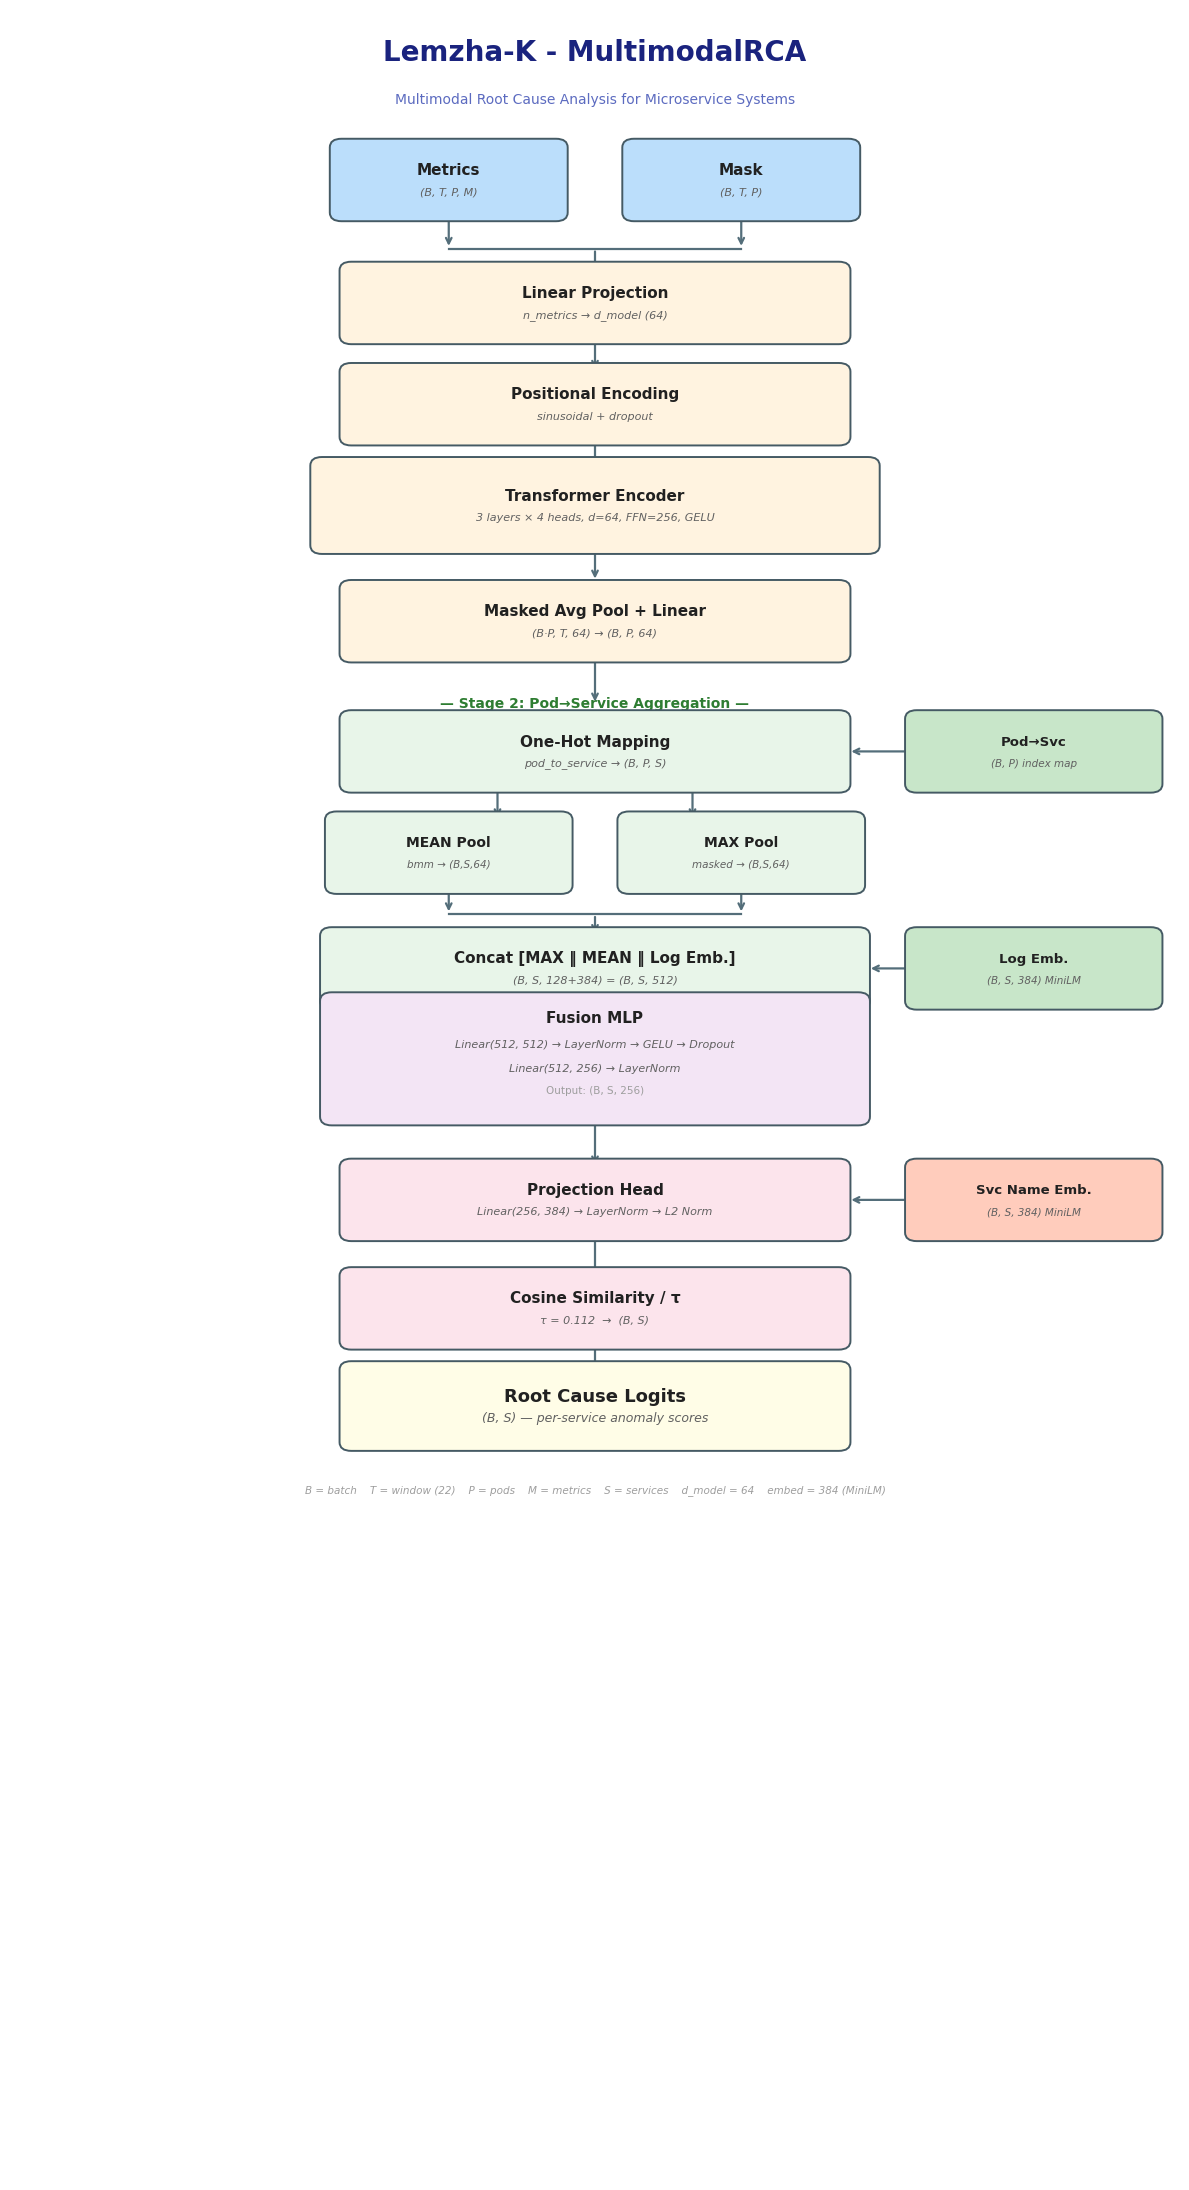

Architecture diagram saved to: ../../model_architecture.png


In [47]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

fig, ax = plt.subplots(1, 1, figsize=(12, 22))
ax.set_xlim(0, 12)
ax.set_ylim(0, 30)
ax.axis('off')
fig.patch.set_facecolor('white')

# ── Colors ──
C = {
    'input': '#BBDEFB', 'input_side': '#C8E6C9', 'input_svc': '#FFCCBC',
    'trans': '#FFF3E0', 'agg': '#E8F5E9', 'fusion': '#F3E5F5',
    'class': '#FCE4EC', 'output': '#FFFDE7',
    'border': '#455A64', 'arrow': '#546E7A', 'stage_bg': '#FAFAFA',
}

# ── Center column X ──
CX = 6.0   # center of the main flow
BW = 5.0   # box width
BH = 0.9   # box height

def box(cx, y, w, h, title, sub, color, title_fs=11, sub_fs=8):
    x = cx - w / 2
    patch = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.12",
                           facecolor=color, edgecolor=C['border'], linewidth=1.4, zorder=3)
    ax.add_patch(patch)
    if sub:
        ax.text(cx, y + h/2 + 0.13, title, ha='center', va='center',
                fontsize=title_fs, fontweight='bold', color='#212121', zorder=4)
        ax.text(cx, y + h/2 - 0.17, sub, ha='center', va='center',
                fontsize=sub_fs, color='#616161', style='italic', zorder=4)
    else:
        ax.text(cx, y + h/2, title, ha='center', va='center',
                fontsize=title_fs, fontweight='bold', color='#212121', zorder=4)

def varrow(x, y_top, y_bot, label=None):
    """Vertical arrow going downward."""
    ax.annotate('', xy=(x, y_bot), xytext=(x, y_top),
                arrowprops=dict(arrowstyle='->', color=C['arrow'], lw=1.6), zorder=2)
    if label:
        ax.text(x + 0.15, (y_top + y_bot) / 2, label, fontsize=7, color='#78909C', va='center')

def harrow(x1, x2, y, label=None):
    """Horizontal arrow."""
    ax.annotate('', xy=(x2, y), xytext=(x1, y),
                arrowprops=dict(arrowstyle='->', color=C['arrow'], lw=1.6), zorder=2)
    if label:
        ax.text((x1 + x2) / 2, y + 0.15, label, fontsize=7, color='#78909C', ha='center')

def side_input_box(cx, y, w, h, title, sub, color):
    box(cx, y, w, h, title, sub, color, title_fs=9.5, sub_fs=7.5)

# ═══════════════════════════════════════════════════════
# TITLE
# ═══════════════════════════════════════════════════════
ax.text(CX, 29.3, 'Lemzha-K - MultimodalRCA', ha='center', fontsize=20, fontweight='bold', color='#1A237E')
ax.text(CX, 28.7, 'Multimodal Root Cause Analysis for Microservice Systems',
        ha='center', fontsize=10, color='#5C6BC0')

# ═══════════════════════════════════════════════════════
# MAIN INPUTS at top (Metrics + Mask)
# ═══════════════════════════════════════════════════════
y = 27.2
box(CX - 1.5, y, 2.2, BH, 'Metrics', '(B, T, P, M)', C['input'])
box(CX + 1.5, y, 2.2, BH, 'Mask', '(B, T, P)', C['input'])

# Arrows down from both inputs merging into center
varrow(CX - 1.5, y, y - 0.5)
varrow(CX + 1.5, y, y - 0.5)
# merge horizontal
ax.plot([CX - 1.5, CX + 1.5], [y - 0.5, y - 0.5], color=C['arrow'], lw=1.6, zorder=2)
varrow(CX, y - 0.5, y - 0.9)

# ═══════════════════════════════════════════════════════
# STAGE 1: METRIC ENCODER
# ═══════════════════════════════════════════════════════
s1_top = 26.0
ax.text(CX, s1_top + 0.2, '— Stage 1: Metric Encoding —', ha='center',
        fontsize=10, fontweight='bold', color='#E65100')

y = s1_top - 0.5
box(CX, y, BW, BH, 'Linear Projection', f'n_metrics → d_model (64)', C['trans'])
varrow(CX, y, y - 0.5)

y -= 1.4
box(CX, y, BW, BH, 'Positional Encoding', 'sinusoidal + dropout', C['trans'])
varrow(CX, y, y - 0.5)

y -= 1.5
box(CX, y, BW + 0.6, 1.1, 'Transformer Encoder', '3 layers × 4 heads, d=64, FFN=256, GELU', C['trans'])
varrow(CX, y, y - 0.5)

y -= 1.5
box(CX, y, BW, BH, 'Masked Avg Pool + Linear', '(B·P, T, 64) → (B, P, 64)', C['trans'])

# Arrow down to Stage 2
varrow(CX, y, y - 0.7)

# ═══════════════════════════════════════════════════════
# STAGE 2: POD→SERVICE AGGREGATION
# ═══════════════════════════════════════════════════════
s2_top = y - 0.9
ax.text(CX, s2_top + 0.15, '— Stage 2: Pod→Service Aggregation —', ha='center',
        fontsize=10, fontweight='bold', color='#2E7D32')

# Side input: Pod→Svc mapping
side_x = 10.5
side_input_box(side_x, s2_top - 0.9, 2.4, BH, 'Pod→Svc', '(B, P) index map', C['input_side'])
harrow(side_x - 1.2, CX + BW/2 + 0.1, s2_top - 0.45)

y = s2_top - 0.9
box(CX, y, BW, BH, 'One-Hot Mapping', 'pod_to_service → (B, P, S)', C['agg'])
varrow(CX - 1.0, y, y - 0.5)
varrow(CX + 1.0, y, y - 0.5)

y -= 1.4
box(CX - 1.5, y, 2.3, BH, 'MEAN Pool', 'bmm → (B,S,64)', C['agg'], 10, 7.5)
box(CX + 1.5, y, 2.3, BH, 'MAX Pool', 'masked → (B,S,64)', C['agg'], 10, 7.5)

# Merge arrows
varrow(CX - 1.5, y, y - 0.4)
varrow(CX + 1.5, y, y - 0.4)
ax.plot([CX - 1.5, CX + 1.5], [y - 0.4, y - 0.4], color=C['arrow'], lw=1.6, zorder=2)
varrow(CX, y - 0.4, y - 0.7)

y -= 1.6
box(CX, y, BW + 0.4, BH, 'Concat [MAX ‖ MEAN ‖ Log Emb.]', '(B, S, 128+384) = (B, S, 512)', C['agg'])

# Side input: Log Embeddings → enters concat from right
side_input_box(side_x, y, 2.4, BH, 'Log Emb.', '(B, S, 384) MiniLM', C['input_side'])
harrow(side_x - 1.2, CX + (BW + 0.4)/2 + 0.1, y + BH/2)

# Arrow down to Stage 3
varrow(CX, y, y - 0.7)

# ═══════════════════════════════════════════════════════
# STAGE 3: FUSION MLP
# ═══════════════════════════════════════════════════════
s3_top = y - 0.9
ax.text(CX, s3_top + 0.15, '— Stage 3: Fusion MLP —', ha='center',
        fontsize=10, fontweight='bold', color='#6A1B9A')

y = s3_top - 0.7
box(CX, y, BW + 0.4, 1.6, '', None, C['fusion'])
ax.text(CX, y + 1.3, 'Fusion MLP',
        ha='center', fontsize=11, fontweight='bold', color='#212121', zorder=4)
ax.text(CX, y + 0.95, 'Linear(512, 512) → LayerNorm → GELU → Dropout',
        ha='center', fontsize=8, color='#616161', style='italic', zorder=4)
ax.text(CX, y + 0.62, 'Linear(512, 256) → LayerNorm',
        ha='center', fontsize=8, color='#616161', style='italic', zorder=4)
ax.text(CX, y + 0.32, 'Output: (B, S, 256)',
        ha='center', fontsize=7.5, color='#9E9E9E', zorder=4)

# Arrow down to Stage 4
varrow(CX, y, y - 0.7)

# ═══════════════════════════════════════════════════════
# STAGE 4: SIMILARITY CLASSIFICATION
# ═══════════════════════════════════════════════════════
s4_top = y - 0.9
ax.text(CX, s4_top + 0.15, '— Stage 4: Similarity Classification —', ha='center',
        fontsize=10, fontweight='bold', color='#B71C1C')

y = s4_top - 0.7
box(CX, y, BW, BH, 'Projection Head', 'Linear(256, 384) → LayerNorm → L2 Norm', C['class'])

# Side input: Service Name Embeddings
side_input_box(side_x, y, 2.4, BH, 'Svc Name Emb.', '(B, S, 384) MiniLM', C['input_svc'])
harrow(side_x - 1.2, CX + BW/2 + 0.1, y + BH/2)

# Both go down
varrow(CX, y, y - 0.7)

y -= 1.5
box(CX, y, BW, BH, 'Cosine Similarity / τ', 'τ = 0.112  →  (B, S)', C['class'])

# Arrow to output
varrow(CX, y, y - 0.7)

# ═══════════════════════════════════════════════════════
# OUTPUT
# ═══════════════════════════════════════════════════════
y -= 1.4
box(CX, y, BW, 1.0, 'Root Cause Logits', '(B, S) — per-service anomaly scores', C['output'], 13, 9)

# ── Legend ──
ax.text(CX, y - 0.7,
        'B = batch    T = window (22)    P = pods    M = metrics    S = services    d_model = 64    embed = 384 (MiniLM)',
        ha='center', fontsize=7.5, color='#9E9E9E', style='italic')

plt.tight_layout()
plt.savefig('../../model_architecture.png', dpi=200, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Architecture diagram saved to: ../../model_architecture.png")